# Modelo

### Librerías y carga del dataset

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import os

# Directorio que contiene los archivos pkl
directorio = '../data/'  # Actualiza con la ruta correcta

# Lista para almacenar los DataFrames de los archivos pkl
dataframes = []

# Recorre los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data = pickle.load(f)
        dataframes.append(data)

# Combina los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

### Datos sin procesar

In [55]:
print(data.head())
print("filas-data-sucia: ", len(data))

   TRANSACTION_ID TIEMPO_DESDE_ULTIMA_TX_S DIA_TX CLIENTE_ID TERMINAL_ID  \
0          386663                  6134814     71       7162         439   
1          386664                  6135010     71       6635         173   
2          386665                  6135020     71       2010         138   
3          386666                  6135040     71        418         116   
4          386667                  6135489     71       5514         426   

    MONTO_TX         TX_DATETIME    year  month  day  hour  minute  \
0  119366.58 2023-04-06 00:06:54  2023.0    4.0  6.0   0.0     6.0   
1   26636.46 2023-04-06 00:10:10  2023.0    4.0  6.0   0.0    10.0   
2   83394.98 2023-04-06 00:10:20  2023.0    4.0  6.0   0.0    10.0   
3  123831.11 2023-04-06 00:10:40  2023.0    4.0  6.0   0.0    10.0   
4   46486.79 2023-04-06 00:18:09  2023.0    4.0  6.0   0.0    18.0   

   x_pos_terminal  y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
0       36.025896       42.367201         1              

### Datos filtrados

In [56]:
data = data.drop('TRANSACTION_ID', axis=1)
data = data.drop('CLIENTE_ID', axis=1)
data = data[data['TX_FRAUD'] == 1]
data = data.sort_values(by=['TX_DATETIME'])
print(data.head())
print("total-filas: ",len(data) )

      TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
27297                     1524      0         429  139447.11   
27302                     1805      0          93   92739.05   
27304                     1911      0         380  115776.96   
27317                     2544      0         233  139610.64   
27318                     2552      0         210  132291.02   

              TX_DATETIME    year  month   day  hour  minute  x_pos_terminal  \
27297 2023-01-25 00:25:24  2023.0    1.0  25.0   0.0    25.0        3.203366   
27302 2023-01-25 00:30:05  2023.0    1.0  25.0   0.0    30.0       49.140856   
27304 2023-01-25 00:31:51  2023.0    1.0  25.0   0.0    31.0       45.234308   
27317 2023-01-25 00:42:24  2023.0    1.0  25.0   0.0    42.0       25.412377   
27318 2023-01-25 00:42:32  2023.0    1.0  25.0   0.0    42.0       28.550428   

       y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
27297       17.765518         1                  1  
27302        9.080643       

### Random Forest

Mean Squared Error (MSE): 0.7634152370953462
Mean Absolute Error (MAE): 0.6442746524190816
R-squared: 0.8809306027136433


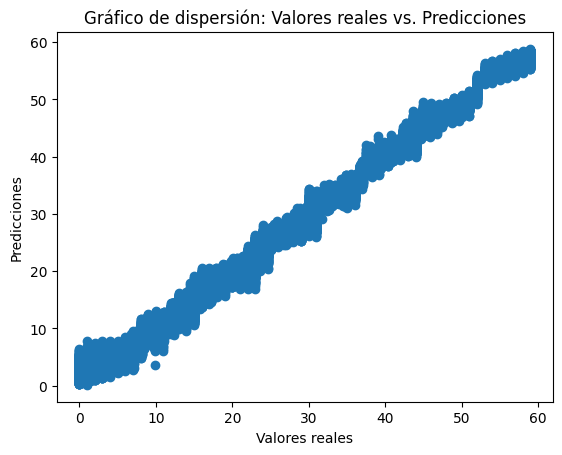

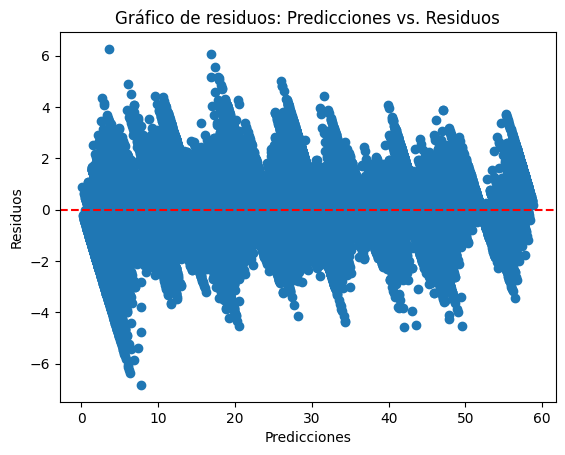

In [57]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
# Variables de entrada
X = data[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y = data[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(oob_score=True)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs. Predicciones')
plt.show()

# Calcular los residuos
residuals = y_test - y_pred

# Gráfico de residuos
plt.scatter(y_pred, residuals)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de residuos: Predicciones vs. Residuos')
plt.axhline(y=0, color='r', linestyle='--')  # Línea de referencia en 0
plt.show()

### Curvas de aprendizaje

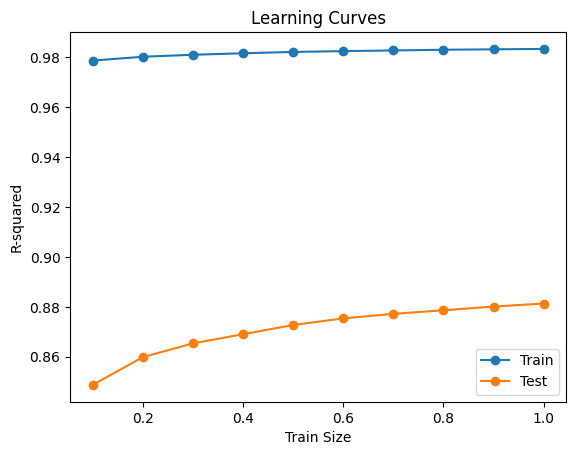

In [58]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []
test_scores = []

for train_size in train_sizes:
    # Tamaño del conjunto de entrenamiento actual
    current_train_size = int(train_size * len(X_train))
    
    # Subconjunto de entrenamiento actual
    X_train_subset = X_train[:current_train_size]
    y_train_subset = y_train[:current_train_size]
    
    # Entrenar el modelo
    model = RandomForestRegressor(oob_score=True)
    model.fit(X_train_subset, y_train_subset)
    
    # Predecir en el conjunto de entrenamiento y prueba
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test)
    
    # Calcular el rendimiento (por ejemplo, R-squared)
    train_score = r2_score(y_train_subset, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Agregar a las listas de puntajes
    train_scores.append(train_score)
    test_scores.append(test_score)

# Graficar las curvas de aprendizaje
plt.plot(train_sizes, train_scores, 'o-', label='Train')
plt.plot(train_sizes, test_scores, 'o-', label='Test')
plt.xlabel('Train Size')
plt.ylabel('R-squared')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [59]:
y_pred_rounded = y_pred.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded[:, -4:] = y_pred_rounded[:, -4:].round().astype(int)

print(y_pred_rounded)
rounded_df = pd.DataFrame(y_pred_rounded, columns=y_test.columns)
rounded_df.to_csv('../output/predicciones.csv', index=False)

[[40.30834185 12.39998297  3.         26.         11.         32.        ]
 [ 8.16513484 34.3136391   2.         27.         14.         48.        ]
 [10.19870261 48.73554927  3.         21.         14.         16.        ]
 ...
 [45.68651599 23.50774536  3.         19.         15.         12.        ]
 [ 3.36474709 26.30884044  3.         20.         10.         20.        ]
 [12.5045635  43.68904079  2.          3.          5.          4.        ]]


### Validación

In [60]:
validacion_directorio = '../validation/'

dataframe_validation = []

for archivo in os.listdir(validacion_directorio):
    if archivo.endswith('.pkl'):
        ruta_archivo = os.path.join(validacion_directorio, archivo)
        with open(ruta_archivo, 'rb') as f:
            data_val = pickle.load(f)
        dataframe_validation.append(data_val)

# Combina los DataFrames en uno solo
data_val = pd.concat(dataframe_validation, ignore_index=True)

In [61]:
data_val = data_val.drop('TRANSACTION_ID', axis=1)
data_val = data_val.drop('CLIENTE_ID', axis=1)
data_val = data_val[data_val['TX_FRAUD'] == 1]
data_val = data_val.sort_values(by=['TX_DATETIME'])
print(data_val.head())
print("total-filas: ",len(data_val) )

      TIEMPO_DESDE_ULTIMA_TX_S DIA_TX TERMINAL_ID   MONTO_TX  \
48368                     1524      0         429  139447.11   
48370                     1805      0          93   92739.05   
48371                     1911      0         380  115776.96   
48374                     3108      0         396  124855.45   
48375                     3445      0         321   82575.39   

              TX_DATETIME    year  month   day  hour  minute  x_pos_terminal  \
48368 2023-02-25 00:25:24  2023.0    2.0  25.0   0.0    25.0        3.203366   
48370 2023-02-25 00:30:05  2023.0    2.0  25.0   0.0    30.0       49.140856   
48371 2023-02-25 00:31:51  2023.0    2.0  25.0   0.0    31.0       45.234308   
48374 2023-02-25 00:51:48  2023.0    2.0  25.0   0.0    51.0       28.535793   
48375 2023-02-25 00:57:25  2023.0    2.0  25.0   0.0    57.0       28.535793   

       y_pos_terminal  TX_FRAUD  TX_FRAUD_SCENARIO  
48368       17.765518         1                  1  
48370        9.080643       

In [62]:
X_val = data_val[['x_pos_terminal', 'y_pos_terminal','month', 'day', 'hour', 'minute']]
# Variables objetivo
y_val = data_val[['x_pos_terminal', 'y_pos_terminal','month','day', 'hour', 'minute']]

# Realizar predicciones en el conjunto de prueba
y_pred_val = model.predict(X_val)

y_pred_val_original = y_pred_val.copy()  # Copia los valores predichos

y_pred_rounded_val = y_pred_val.copy()  # Copia los valores predichos

# Redondea los valores a enteros en las últimas 4 columnas
y_pred_rounded_val[:, -4:] = y_pred_rounded_val[:, -4:].round().astype(int)

print(y_pred_rounded_val)
rounded_df_val = pd.DataFrame(y_pred_rounded_val, columns=y_val.columns)
rounded_df_val.to_csv('../output/predicciones_val.csv', index=False)

# Calcular las métricas
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Imprimir las métricas
print("VAL - Mean Squared Error (MSE):", mse_val)
print("VAL - Mean Absolute Error (MAE):", mae_val)
print("VAL - R-squared:", r2_val)


[[ 2.63689129 17.81972457  3.         26.          2.         25.        ]
 [48.97181482  9.00013749  2.         25.          2.         30.        ]
 [46.6017058   2.7003194   2.         25.          2.         32.        ]
 ...
 [48.74576022  8.56292759  3.         15.         23.         43.        ]
 [19.19408029 30.33584697  3.         14.         22.         48.        ]
 [39.40294604  1.85818005  3.         15.         22.         55.        ]]
VAL - Mean Squared Error (MSE): 0.5281484480256243
VAL - Mean Absolute Error (MAE): 0.5221550070686213
VAL - R-squared: 0.7979028611644665


In [63]:
print(y_pred_val_original)

[[ 2.63689129 17.81972457  2.6        25.64        2.42       25.17      ]
 [48.97181482  9.00013749  1.5        25.24        1.56       30.41      ]
 [46.6017058   2.7003194   1.72       24.92        2.04       31.69      ]
 ...
 [48.74576022  8.56292759  3.46       14.61       22.72       42.56      ]
 [19.19408029 30.33584697  3.3        14.28       22.1        47.91      ]
 [39.40294604  1.85818005  2.93       14.54       22.32       54.7       ]]
